- Discriminator においては、pooling ではなく stride によるダウンサンプリングを行う。 Generator では、転置畳み込みを使用してアップサンプリングを行う。
- Generator と Discriminator に BatchNormalization を使用する
- 隠れ層の全結合層は除く
- Generator の活性化関数には ReLU を用い、出力層のみ Tanh を用いる
- Discriminator の全ての層の活性化関数に、LeakyReLU を使用する

### データセットの準備

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms

np.random.seed(0)
torch.manual_seed(0)

In [2]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


### モデルの定義

In [3]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super().__init__()

        self.conv_dim = conv_dim
        self.conv = nn.Sequential(
            # input: 32 x 32
            nn.Conv2d(in_channels=3, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # 16 x 16
            nn.Conv2d(conv_dim, conv_dim*2, 4, 2, 1), 
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 8 x 8 
            nn.Conv2d(conv_dim*2, conv_dim*4, 4, 2, 1),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # output: 4 x 4
        )
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, conv_dim=32):
        super().__init__()
        self.conv_dim = conv_dim 
        self.fc = nn.Linear(z_dim, conv_dim*4*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        out = self.deconv(out)
        return out

### 損失関数

In [6]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels.to(device))
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels.to(device))
    return loss

### 学習の手順

#### Discriminator
1. 本物画像で discriminator loss を計算
2. 偽物画像を generator で生成
3. 偽物画像で discriminator loss を計算
4. 2 つの discriminator loss を合算
5. 合算した loss を元に逆伝播・パラメータ更新

#### Generator
1. 偽物画像を generator で生成
2. 偽物画像で disciminator loss を計算（ label を反転させる ）
3. 逆伝播・パラメータ更新

In [7]:
num_epochs = 50
z_dim = 100
lr = 1e-4 
conv_dim = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
D = Discriminator(conv_dim).to(device)
G = Generator(z_dim=z_dim, conv_dim=conv_dim).to(device)
d_optim = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optim = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


  
for epoch in range(num_epochs):

  for idx, (real_imgs, _) in enumerate(train_loader):
    batch_size = real_imgs.size(0)

    # rescaling 0~1 -> -1~1
    real_imgs = real_imgs * 2 - 1 
    real_imgs = real_imgs.to(device)

    # =============================
    # TRAIN THE DISCRIMINATOR
    # =============================

    d_optim.zero_grad()

    # 本物画像で discriminator loss を計算
    D_real = D(real_imgs)
    d_real_loss = real_loss(D_real)

    # 偽物画像を generator で生成
    z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    z = torch.from_numpy(z).float().to(device)
    fake_imgs = G(z)

    # 偽物画像で discriminator loss を計算
    D_fake = D(fake_imgs)
    d_fake_loss = fake_loss(D_fake)

    # 合算した loss を元に逆伝播・パラメータ更新
    d_loss = d_real_loss + d_fake_loss 
    d_loss.backward()
    d_optim.step()

    # =============================
    # TRAIN THE GENERATOR
    # =============================

    g_optim.zero_grad()

    # 偽物画像を generator で生成
    z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    z = torch.from_numpy(z).float().to(device)
    fake_imgs = G(z)

    # 偽物画像で disciminator loss を計算（ label を反転させる ）
    D_fake = D(fake_imgs)
    g_loss = real_loss(D_fake) # ここで fake_loss ではなく real_loss を用いる点がポイント

    # 逆伝播・パラメータ更新
    g_loss.backward()
    g_optim.step()

  # エポックごとにログを表示
  print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/   50] | d_loss: 0.2342 | g_loss: 2.7285
Epoch [    2/   50] | d_loss: 0.4036 | g_loss: 2.3579
Epoch [    3/   50] | d_loss: 0.4289 | g_loss: 3.5510
Epoch [    4/   50] | d_loss: 0.2662 | g_loss: 2.4498
Epoch [    5/   50] | d_loss: 0.2448 | g_loss: 3.3709
Epoch [    6/   50] | d_loss: 0.1850 | g_loss: 3.2804
Epoch [    7/   50] | d_loss: 0.2330 | g_loss: 2.9932
Epoch [    8/   50] | d_loss: 0.2973 | g_loss: 3.7349
Epoch [    9/   50] | d_loss: 0.2345 | g_loss: 3.5905
Epoch [   10/   50] | d_loss: 0.2512 | g_loss: 3.3480
Epoch [   11/   50] | d_loss: 0.2427 | g_loss: 3.1734
Epoch [   12/   50] | d_loss: 0.3154 | g_loss: 2.8746
Epoch [   13/   50] | d_loss: 0.2552 | g_loss: 3.0863
Epoch [   14/   50] | d_loss: 0.2149 | g_loss: 2.9894
Epoch [   15/   50] | d_loss: 0.2204 | g_loss: 3.3595
Epoch [   16/   50] | d_loss: 0.2921 | g_loss: 3.1760
Epoch [   17/   50] | d_loss: 0.1872 | g_loss: 3.0369
Epoch [   18/   50] | d_loss: 0.3151 | g_loss: 3.6578
Epoch [   19/   50] | d_loss

### 画像を生成

In [8]:
# 100 次元のノイズを 25 個作成
z_dim = 100
z = np.random.uniform(-1, 1, size=(25, z_dim))
z = torch.from_numpy(z).float().to(device)

G.eval().to(device)

# Generator に通して偽物画像を生成する
fake_images = G(z)

fake_images.size()

torch.Size([25, 3, 32, 32])

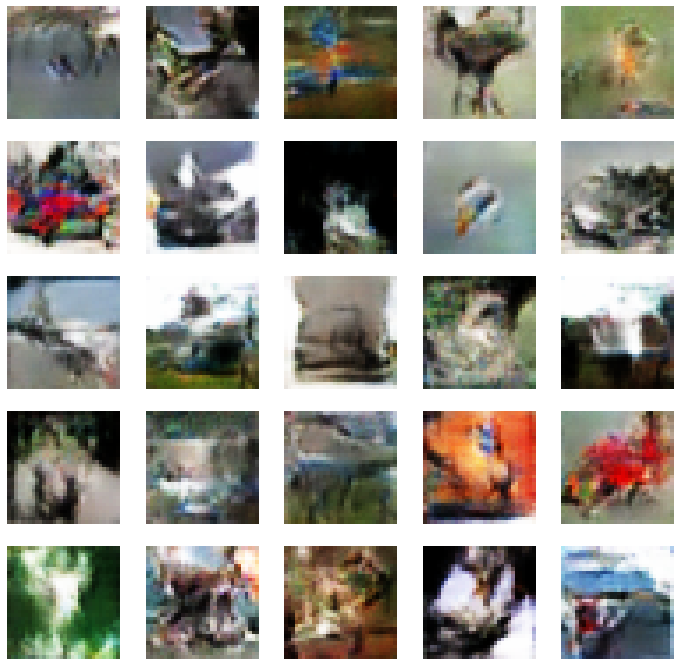

In [9]:
plt.figure(figsize=(12, 12))

for i in range(25):
    img = fake_images[i].cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img + 1) * 255 / 2).astype(np.uint8) # rescaling
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(img)